In [1]:
pip install catboost

     |████████████████████████████████| 62.9MB 40kB/s 


In [2]:
# Load Python libraries
from sklearn import model_selection, ensemble, metrics
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, f1_score, accuracy_score
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Load data
df = pd.read_csv('drive/My Drive/Colab Notebooks/datasets/train.csv')

df = df.sample(frac=0.05)

# Load and join songs data
songs = pd.read_csv('drive/My Drive/Colab Notebooks/datasets/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

# Load and join songs data
members = pd.read_csv('drive/My Drive/Colab Notebooks/datasets/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

# Replace NA
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

# Create Dates

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

# # Select columns
# df = df[['msno', 'song_id', 'source_screen_name', 'source_type', 'target',
#        'song_length', 'artist_name', 'composer', 'bd',
#        'registration_init_time', 'registration_init_time_month',
#        'registration_init_time_day', 'expiration_date_day']]

# Dates to categoty
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,14687,16315,0,4,9,1,260179.0,203,11648,18298,7192,3.0,1,0,2,9,3665,824,2016,11,5,2017,11,12
1,20356,37347,3,8,3,1,251712.0,200,11384,19243,10532,3.0,22,17,0,4,3743,764,2017,1,22,2017,9,13
2,6920,51848,3,8,4,1,229537.0,49,9878,18298,7192,52.0,14,30,1,9,2048,790,2011,12,7,2017,10,9
3,4776,31603,3,8,3,1,229564.0,49,13510,22234,11416,3.0,1,0,2,4,3435,797,2016,1,16,2017,10,16
4,1205,14232,0,11,6,0,279196.0,200,11159,18994,8847,3.0,22,31,1,3,3220,767,2015,6,15,2017,9,16


In [0]:
# # # Train & Test split
target = df.pop('target')
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(df, target, test_size = 0.3, random_state=40)

In [6]:
len(train_data)

258209

Data Loading and train test sample creation is done. Now Lets start with the classifiers training. 

1.DT
2.ET
3.KNN
3.BaggingDT
4.BaggingET
5.RandomForest
6.XGB
7.LightGBM
8.CatBoost
9.BoostStack
10.BaggingStack ?????
11.VotingEnsemble

In [7]:
dtclf = DecisionTreeClassifier(criterion='entropy', 
                               splitter='best', 
                               max_depth=20, 
                               min_samples_split=2, 
                               min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, 
                               max_features=0.8, 
                               min_impurity_decrease=0.0)
dtclf.fit(train_data, train_labels)



# # # Predicting
predict_labels_dt = dtclf.predict(test_data)
print(metrics.classification_report(test_labels, predict_labels_dt))

              precision    recall  f1-score   support

           0       0.63      0.57      0.60     54803
           1       0.61      0.66      0.64     55859

    accuracy                           0.62    110662
   macro avg       0.62      0.62      0.62    110662
weighted avg       0.62      0.62      0.62    110662



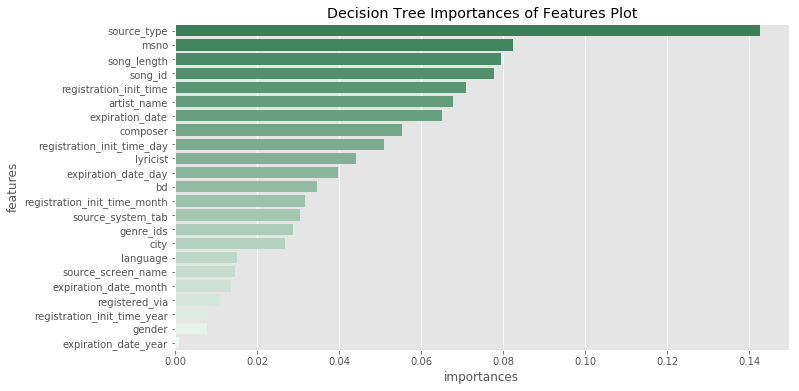

In [0]:
df_plot = pd.DataFrame({'features': train_data.columns,
                        'importances': dtclf.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

plt.figure(figsize=[11,6])
sns.barplot(x = df_plot.importances, y = df_plot.features, palette = sns.light_palette("seagreen", reverse=True, n_colors = 23))
# sns.set_context("poster")
plt.title('Decision Tree Importances of Features Plot')
plt.show()

<Figure size 432x288 with 0 Axes>

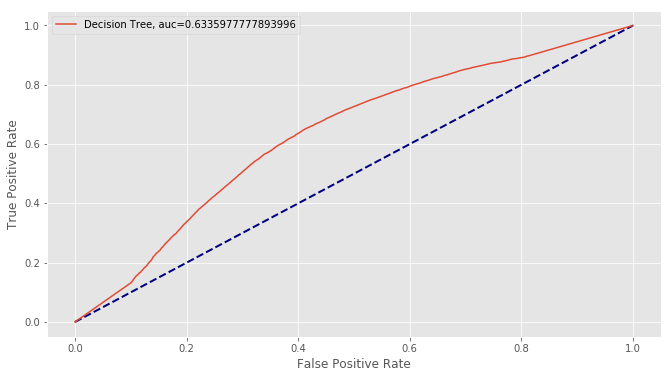

In [0]:
plt.clf()
plt.figure(figsize=(11,6))
pred_labels_dtclf_proba = dtclf.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  pred_labels_dtclf_proba)
auc = metrics.roc_auc_score(test_labels, pred_labels_dtclf_proba)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr,label="Decision Tree, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='medium')
plt.show()

In [29]:
extraclf = ExtraTreesClassifier(criterion='gini', 
                                max_depth=18, 
                                min_samples_split=2, 
                                min_samples_leaf=1,
                                min_impurity_split=1e-7, 
                                max_features='auto')
extraclf.fit(train_data, train_labels)




# # # Predicting
predict_labels_extra = extraclf.predict(test_data)
print(metrics.classification_report(test_labels, predict_labels_extra))

              precision    recall  f1-score   support

           0       0.64      0.61      0.62     54803
           1       0.63      0.67      0.65     55859

    accuracy                           0.64    110662
   macro avg       0.64      0.64      0.64    110662
weighted avg       0.64      0.64      0.64    110662



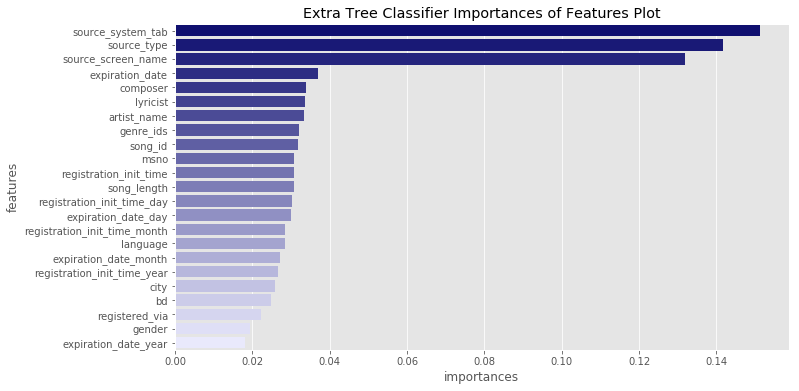

In [0]:
df_plot = pd.DataFrame({'features': train_data.columns,
                        'importances': extraclf.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

plt.figure(figsize=[11,6])
sns.barplot(x = df_plot.importances, y = df_plot.features, palette = sns.light_palette("navy", reverse=True, n_colors = 23))
# sns.set_context("poster")
plt.title('Extra Tree Classifier Importances of Features Plot')
plt.show()

<Figure size 432x288 with 0 Axes>

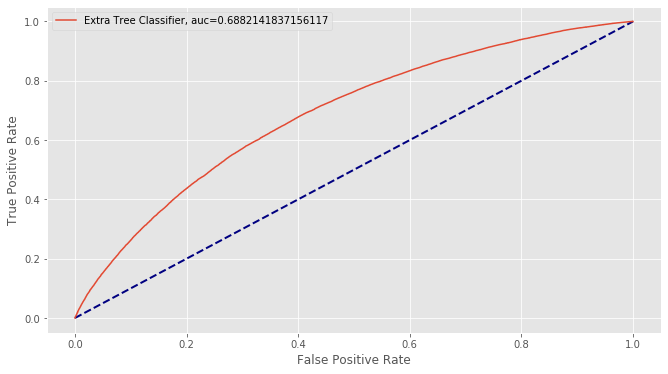

In [26]:
plt.clf()
plt.figure(figsize=(11,6))
pred_labels_extraclf_proba = extraclf.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  pred_labels_extraclf_proba)
auc = metrics.roc_auc_score(test_labels, pred_labels_extraclf_proba)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr,label="Extra Tree Classifier, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='medium')
plt.show()

In [0]:
# base_estimator=dtclf is the previously implemented decision tree classifier
baggingDT = BaggingClassifier(base_estimator=dtclf, 
                              n_estimators=20, 
                              max_samples=0.8, 
                              max_features=0.8,
                              bootstrap=True,
                              )
baggingDT.fit(train_data, train_labels)


# # # Predicting
# predict_labels_baggingDT = baggingDT.predict(test_data)
# print(metrics.classification_report(test_labels, predict_labels_baggingDT))

<Figure size 432x288 with 0 Axes>

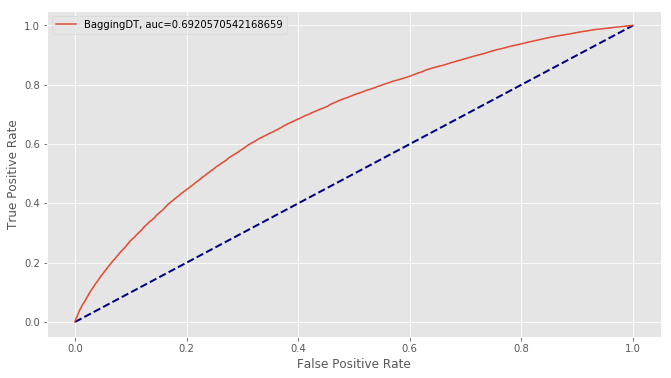

In [0]:
plt.clf()
plt.figure(figsize=(11,6))
pred_labels_baggingdt_proba = baggingDT.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  pred_labels_baggingdt_proba)
auc = metrics.roc_auc_score(test_labels, pred_labels_baggingdt_proba)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr,label="BaggingDT, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='medium')
plt.show()

In [30]:
baggingET = BaggingClassifier(base_estimator=extraclf, n_estimators=20, max_samples=0.8, max_features=0.8)
baggingET.fit(train_data, train_labels)

# # Predicting
predict_labels_baggingET = baggingET.predict(test_data)
print(metrics.classification_report(test_labels, predict_labels_baggingET))

              precision    recall  f1-score   support

           0       0.64      0.65      0.64     54803
           1       0.65      0.64      0.64     55859

    accuracy                           0.64    110662
   macro avg       0.64      0.64      0.64    110662
weighted avg       0.64      0.64      0.64    110662



<Figure size 432x288 with 0 Axes>

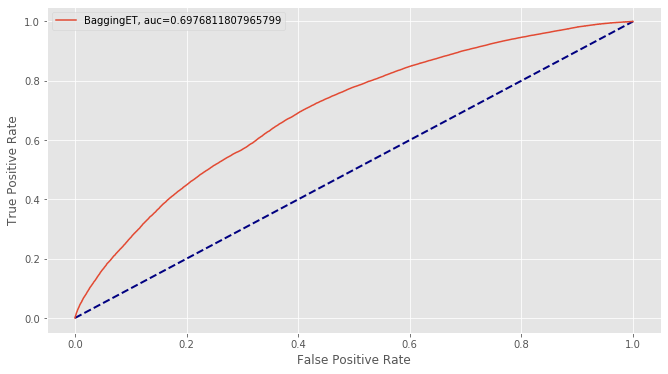

In [31]:
plt.clf()
plt.figure(figsize=(11,6))
pred_labels_bagginget_proba = baggingET.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  pred_labels_bagginget_proba)
auc = metrics.roc_auc_score(test_labels, pred_labels_bagginget_proba)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr,label="BaggingET, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='medium')
plt.show()

In [13]:
#KNN

%%time
# Create model


knnclf = KNeighborsClassifier(n_neighbors=5, weights='uniform',
                     algorithm='auto', 
                     leaf_size=30, p=2, 
                     metric='euclidean')
knnclf.fit(train_data, train_labels)



# Predicting
predict_labels5 = knnclf.predict(test_data)
print(metrics.classification_report(test_labels, predict_labels5))



              precision    recall  f1-score   support

           0       0.53      0.51      0.52     54803
           1       0.54      0.56      0.55     55859

    accuracy                           0.53    110662
   macro avg       0.53      0.53      0.53    110662
weighted avg       0.53      0.53      0.53    110662

CPU times: user 11.7 s, sys: 11.7 ms, total: 11.7 s
Wall time: 11.7 s


<Figure size 432x288 with 0 Axes>

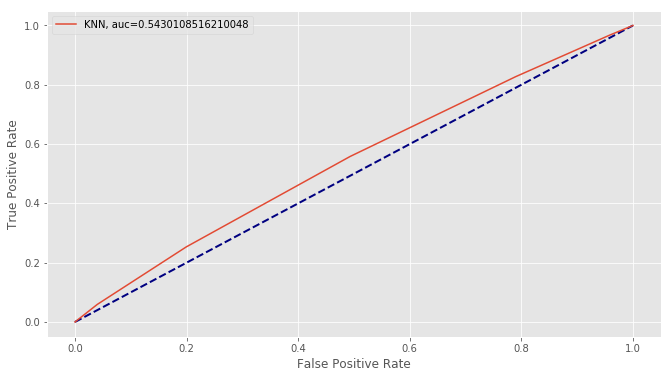

In [0]:
plt.clf()
plt.figure(figsize=(11,6))
pred_labels_knn_proba = knn.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  pred_labels_knn_proba)
auc = metrics.roc_auc_score(test_labels, pred_labels_knn_proba)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='medium')
plt.show()

In [0]:
baggingKnn = BaggingClassifier(base_estimator=knn, n_estimators=50, max_samples=0.8, max_features=0.8)
baggingKnn.fit(train_data, train_labels)

# # Predicting
predict_labels_baggingKnn = baggingKnn.predict(test_data)
print(metrics.classification_report(test_labels, predict_labels_baggingKnn))

              precision    recall  f1-score   support

           0       0.55      0.53      0.54     36692
           1       0.55      0.57      0.56     37083

    accuracy                           0.55     73775
   macro avg       0.55      0.55      0.55     73775
weighted avg       0.55      0.55      0.55     73775



<Figure size 432x288 with 0 Axes>

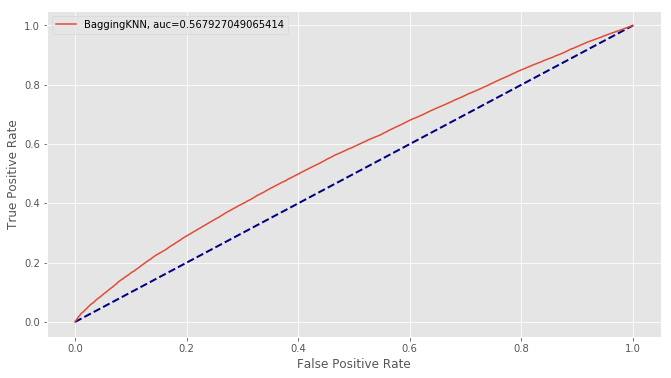

In [0]:
plt.clf()
plt.figure(figsize=(11,6))
pred_labels_bagknn_proba = baggingKnn.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  pred_labels_bagknn_proba)
auc = metrics.roc_auc_score(test_labels, pred_labels_bagknn_proba)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr,label="BaggingKNN, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='medium')
plt.show()

In [15]:
%%time

# Create model


rfmodel = ensemble.RandomForestClassifier(n_estimators= 150, 
                       criterion='entropy', 
                       max_depth=30, 
                       min_samples_split=2, 
                       min_samples_leaf=1, 
                       max_features='auto',  
                       bootstrap=True)
rfmodel.fit(train_data, train_labels)


# # # Predicting
predict_labels_rf = rfmodel.predict(test_data)
print(metrics.classification_report(test_labels, predict_labels_rf))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65     54803
           1       0.66      0.69      0.67     55859

    accuracy                           0.66    110662
   macro avg       0.66      0.66      0.66    110662
weighted avg       0.66      0.66      0.66    110662

CPU times: user 3min 51s, sys: 849 ms, total: 3min 52s
Wall time: 3min 52s


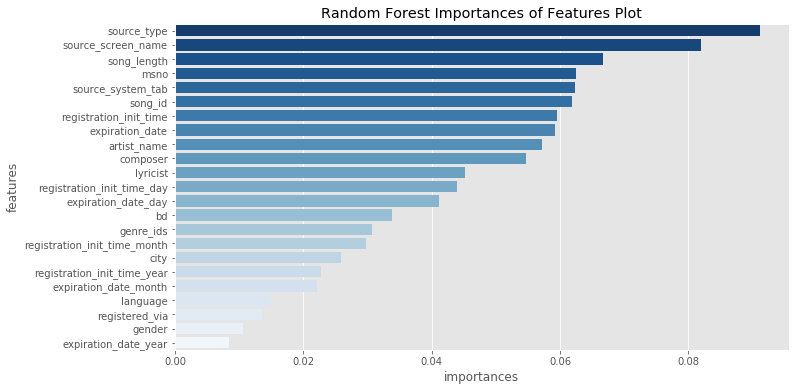

In [0]:
df_plot = pd.DataFrame({'features': train_data.columns,
                        'importances': rfmodel.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

plt.figure(figsize=[11,6])
sns.barplot(x = df_plot.importances, y = df_plot.features, palette = sns.color_palette("Blues_r", n_colors = 23))
# sns.set_context("poster")
plt.title('Random Forest Importances of Features Plot')
plt.show()

<Figure size 432x288 with 0 Axes>

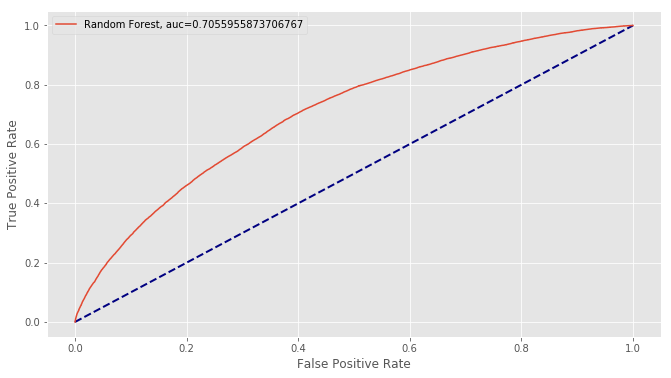

In [0]:
plt.clf()
plt.figure(figsize=(11,6))
pred_labels_rf_proba = rfmodel.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  pred_labels_rf_proba)
auc = metrics.roc_auc_score(test_labels, pred_labels_rf_proba)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='medium')
plt.show()

In [19]:
# Boosting

%%time
# Create model

xgbparams = {
        "booster" : "gbtree",
        "learning_rate" : 0.1, 
        "min_split_loss" : 0,
        "tree_method" : 'auto',
        "max_depth" : 10,
        "grow_policy" : 'depthwise',
        "min_child_weight" : 10,
    }
xgbmodel = xgb.XGBClassifier(**xgbparams, n_estimators=150)
xgbmodel.fit(train_data, train_labels)


# # Predicting
predict_labels_xgb = xgbmodel.predict(test_data)
print(metrics.classification_report(test_labels, predict_labels_xgb))


              precision    recall  f1-score   support

           0       0.66      0.61      0.64     54803
           1       0.65      0.69      0.67     55859

    accuracy                           0.65    110662
   macro avg       0.65      0.65      0.65    110662
weighted avg       0.65      0.65      0.65    110662

CPU times: user 2min 25s, sys: 94.9 ms, total: 2min 25s
Wall time: 2min 25s


In [20]:
print(metrics.confusion_matrix(test_labels, predict_labels_xgb))

[[33515 21288]
 [17102 38757]]


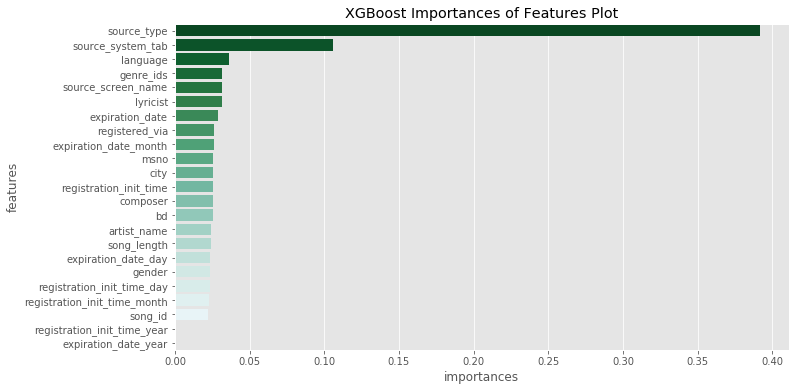

In [0]:
df_plot = pd.DataFrame({'features': train_data.columns,
                        'importances': xgbmodel.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

plt.figure(figsize=[11,6])
sns.barplot(x = df_plot.importances, y = df_plot.features, palette = sns.color_palette("BuGn_r", n_colors = 23))
# sns.set_context("poster")
plt.title('XGBoost Importances of Features Plot')
plt.show()

<Figure size 432x288 with 0 Axes>

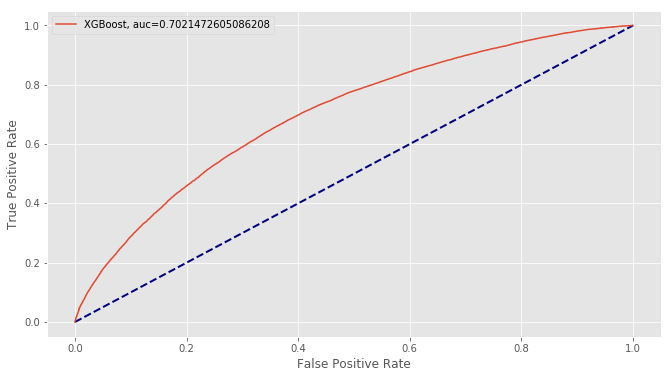

In [0]:
plt.clf()
plt.figure(figsize=(11,6))
pred_labels_xgb_proba = xgbmodel.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  pred_labels_xgb_proba)
auc = metrics.roc_auc_score(test_labels, pred_labels_xgb_proba)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr,label="XGBoost, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='medium')
plt.show()

In [22]:
# %%time

# Create model

catboostparams = {
        "iterations" : 300,
        "learning_rate" : 0.01, 
        "depth" : 16,
        "loss_function" : 'Logloss',
        "border_count" : 128,
        "boosting_type" : 'Plain',
        "bootstrap_type" : 'Bayesian',
        "grow_policy": 'SymmetricTree'
    }
catboost = CatBoostClassifier(**catboostparams)
catboost.fit(train_data, train_labels)


# # Predicting
predict_labels_cat = catboost.predict(test_data)
print(metrics.classification_report(test_labels, predict_labels_cat))

0:	learn: 0.6923425	total: 208ms	remaining: 1m 2s
1:	learn: 0.6914885	total: 325ms	remaining: 48.4s
2:	learn: 0.6906966	total: 448ms	remaining: 44.4s
3:	learn: 0.6899030	total: 567ms	remaining: 41.9s
4:	learn: 0.6891264	total: 689ms	remaining: 40.7s
5:	learn: 0.6883463	total: 805ms	remaining: 39.4s
6:	learn: 0.6876324	total: 927ms	remaining: 38.8s
7:	learn: 0.6868844	total: 1.04s	remaining: 38.2s
8:	learn: 0.6861773	total: 1.17s	remaining: 38s
9:	learn: 0.6854846	total: 1.29s	remaining: 37.5s
10:	learn: 0.6848031	total: 1.42s	remaining: 37.2s
11:	learn: 0.6841421	total: 1.53s	remaining: 36.8s
12:	learn: 0.6834610	total: 1.66s	remaining: 36.7s
13:	learn: 0.6828321	total: 1.78s	remaining: 36.3s
14:	learn: 0.6821994	total: 1.9s	remaining: 36.1s
15:	learn: 0.6815843	total: 2.02s	remaining: 35.8s
16:	learn: 0.6809897	total: 2.14s	remaining: 35.6s
17:	learn: 0.6803859	total: 2.25s	remaining: 35.3s
18:	learn: 0.6797901	total: 2.38s	remaining: 35.2s
19:	learn: 0.6792014	total: 2.5s	remaining: 

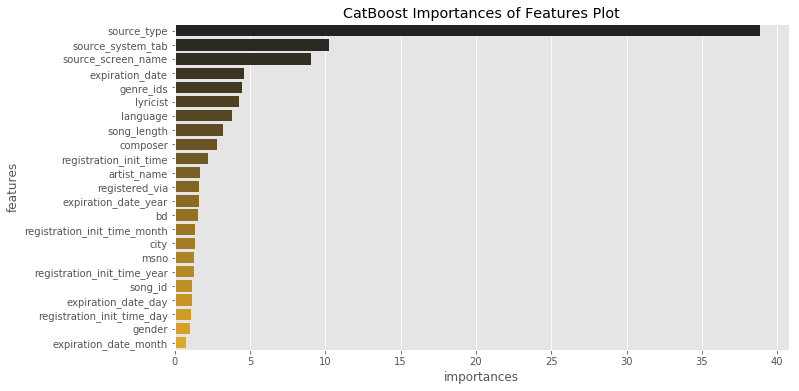

In [0]:
df_plot = pd.DataFrame({'features': train_data.columns,
                        'importances': catboost.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

plt.figure(figsize=[11,6])
sns.barplot(x = df_plot.importances, y = df_plot.features, palette = sns.dark_palette("amber", input="xkcd", n_colors = 23))
# sns.set_context("poster")
plt.title('CatBoost Importances of Features Plot')
plt.show()

<Figure size 432x288 with 0 Axes>

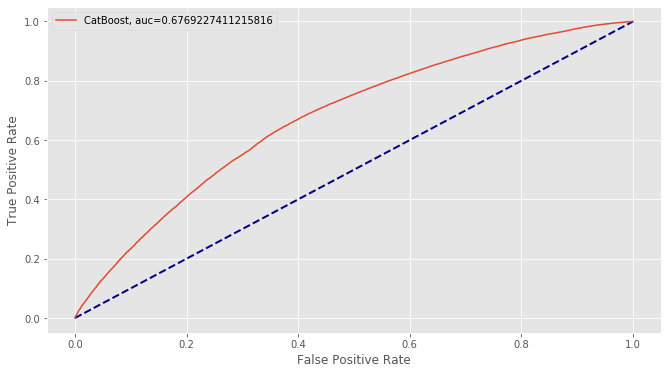

In [23]:
plt.clf()
plt.figure(figsize=(11,6))
pred_labels_catboost_proba = catboost.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  pred_labels_catboost_proba)
auc = metrics.roc_auc_score(test_labels, pred_labels_catboost_proba)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr,label="CatBoost, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='medium')
plt.show()

In [25]:
# Create model
params = {
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'learning_rate': 0.01,
        'metric': 'binary_logloss',
        'metric': 'auc',
        'min_data_in_bin': 3,
        'max_depth': 10,
        'num_boost_round': 1000,
        'objective': 'binary',
        'verbose': 1,
        'num_leaves': 2**6,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 228,
        'num_rounds': 1000,
         }

# params = {
#         "objective" : "binary",
#         "metric" : "binary_logloss", 
#         "num_leaves" : 15,
#         "min_child_samples" : 100,
#         "learning_rate" : 0.5,
#         "bagging_fraction" : 0.7,
#         "feature_fraction" : 0.7,
#         "bagging_frequency" : 5,
#         "bagging_seed" : 2018,
#     }

lgbmodel = lgb.LGBMClassifier(**params, n_estimators = 300)
lgbmodel.fit(train_data, train_labels)

# # Predicting
predict_labels_lgbm = lgbmodel.predict(test_data)
print(metrics.classification_report(test_labels, predict_labels_lgbm))

              precision    recall  f1-score   support

           0       0.65      0.62      0.64     54803
           1       0.64      0.67      0.66     55859

    accuracy                           0.65    110662
   macro avg       0.65      0.65      0.65    110662
weighted avg       0.65      0.65      0.65    110662



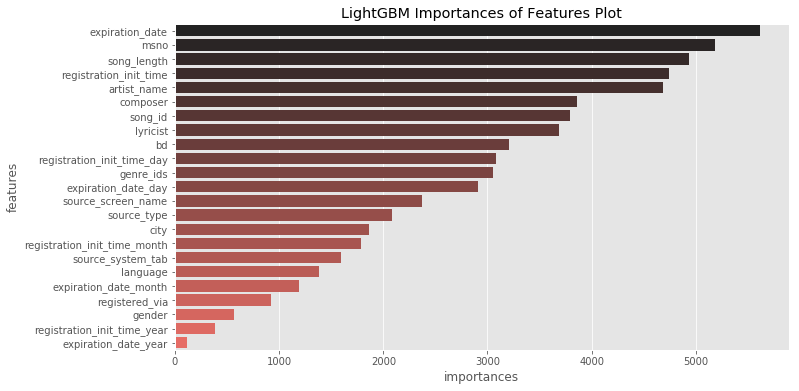

In [0]:
df_plot = pd.DataFrame({'features': train_data.columns,
                        'importances': lgbmodel.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

plt.figure(figsize=[11,6])
sns.barplot(x = df_plot.importances, y = df_plot.features, palette = sns.dark_palette("coral", input="xkcd", n_colors = 23))
# sns.set_context("poster")
plt.title('LightGBM Importances of Features Plot')
plt.show()

<Figure size 432x288 with 0 Axes>

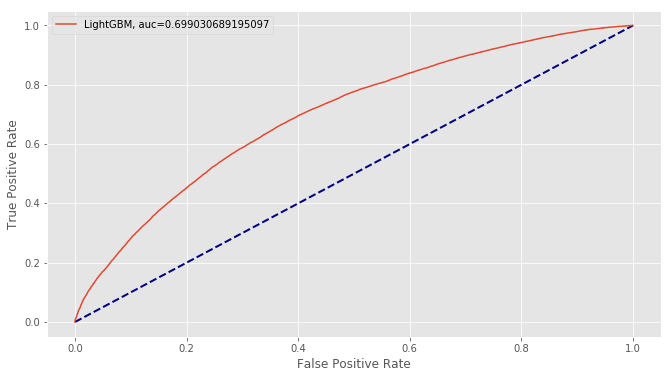

In [0]:
plt.clf()
plt.figure(figsize=(11,6))
pred_labels_lgbm_proba = lgbmodel.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  pred_labels_lgbm_proba)
auc = metrics.roc_auc_score(test_labels, pred_labels_lgbm_proba)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr,label="LightGBM, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='medium')
plt.show()

In [0]:
# Boosting Stack
lr = LogisticRegression()


gaussainNb = GaussianNB(priors=None, 
                var_smoothing=1e-9)

# Stacking Ensemble for Bagging Classifiers
bag_sclf = StackingClassifier(classifiers=[rfmodel, baggingDT, baggingET], 
                              meta_classifier=gaussainNb, 
                              use_probas=True,
                              average_probas=False)

# Stacking Ensemble for Boosting Classifiers
boost_sclf = StackingClassifier(classifiers=[xgbmodel, catboost, lgbmodel], 
                                meta_classifier=gaussainNb, 
                                use_probas=True,
                                average_probas=False)










boost_sclf.fit(train_data, train_labels)
# # Predicting
# predict_labels_boost_sclf = boost_sclf.predict(test_data)
# print(metrics.classification_report(test_labels, predict_labels_boost_sclf))

<Figure size 432x288 with 0 Axes>

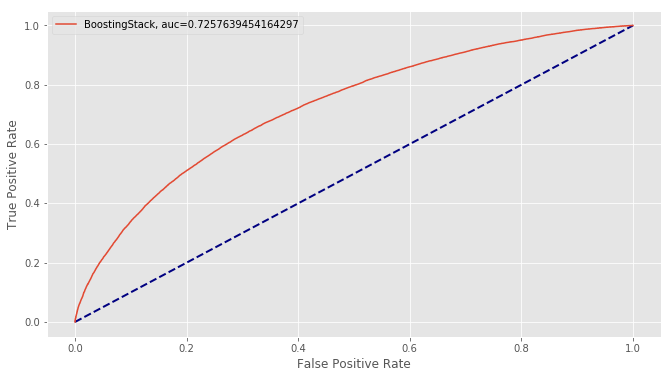

In [0]:
plt.clf()
plt.figure(figsize=(11,6))
pred_labels_sclf_proba = boost_sclf.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  pred_labels_sclf_proba)
auc = metrics.roc_auc_score(test_labels, pred_labels_sclf_proba)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr,label="BoostingStack, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='medium')
plt.show()

In [0]:
#Bagging stack

bag_sclf = StackingClassifier(classifiers=[rfmodel, baggingDT, baggingET], meta_classifier=nb, use_probas=True,
                          average_probas=False)

# bag_sclf.fit(train_data, train_labels)

# # Predicting
# predict_labels_bagging_sclf = bag_sclf.predict(test_data)
# print(metrics.classification_report(test_labels, predict_labels_bagging_sclf))

<Figure size 432x288 with 0 Axes>

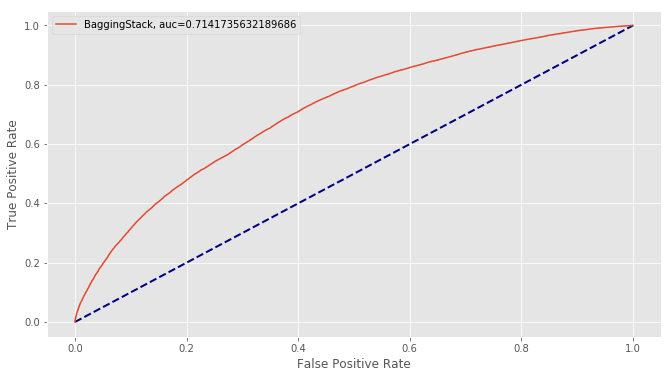

In [0]:
plt.clf()
plt.figure(figsize=(11,6))
pred_labels_bagsclf_proba = bag_sclf.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  pred_labels_bagsclf_proba)
auc = metrics.roc_auc_score(test_labels, pred_labels_bagsclf_proba)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr,label="BaggingStack, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='medium')
plt.show()

In [0]:

# Voting Classifier for the Stacking Ensembles
eclf = VotingClassifier(estimators=[('BaggingStack', bag_sclf), 
                                    ('BoostingStack',boost_sclf)],
                        voting='soft',
                        flatten_transform=True)



# eclf.fit(train_data, train_labels)

# # Predicting
# predict_labels_eclf = eclf.predict(test_data)
# print(metrics.classification_report(test_labels, predict_labels_eclf))

<Figure size 432x288 with 0 Axes>

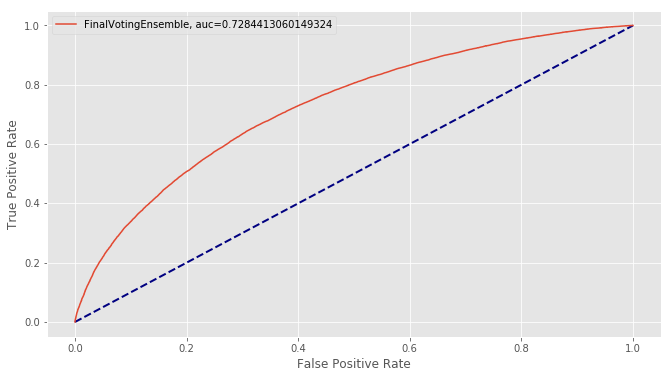

In [0]:
plt.clf()
plt.figure(figsize=(11,6))
pred_labelseclf_proba = eclf.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  pred_labelseclf_proba)
auc = metrics.roc_auc_score(test_labels, pred_labelseclf_proba)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr,label="FinalVotingEnsemble, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='medium')
plt.show()

0:	learn: 0.6921270	total: 2.48s	remaining: 12m 20s
1:	learn: 0.6911429	total: 4.18s	remaining: 10m 22s
2:	learn: 0.6902124	total: 5.82s	remaining: 9m 36s
3:	learn: 0.6892350	total: 7.5s	remaining: 9m 15s
4:	learn: 0.6883382	total: 9.18s	remaining: 9m 1s
5:	learn: 0.6873847	total: 10.9s	remaining: 8m 53s
6:	learn: 0.6864090	total: 12.6s	remaining: 8m 46s
7:	learn: 0.6855050	total: 14.3s	remaining: 8m 41s
8:	learn: 0.6845736	total: 16s	remaining: 8m 37s
9:	learn: 0.6837192	total: 17.7s	remaining: 8m 32s
10:	learn: 0.6829231	total: 19.3s	remaining: 8m 28s
11:	learn: 0.6820669	total: 21s	remaining: 8m 24s
12:	learn: 0.6812644	total: 22.7s	remaining: 8m 21s
13:	learn: 0.6803652	total: 24.4s	remaining: 8m 19s
14:	learn: 0.6795526	total: 26.1s	remaining: 8m 16s
15:	learn: 0.6787309	total: 27.8s	remaining: 8m 13s
16:	learn: 0.6778062	total: 29.5s	remaining: 8m 11s
17:	learn: 0.6770504	total: 31.2s	remaining: 8m 8s
18:	learn: 0.6762073	total: 32.9s	remaining: 8m 6s
19:	learn: 0.6754510	total: 

<Figure size 432x288 with 0 Axes>

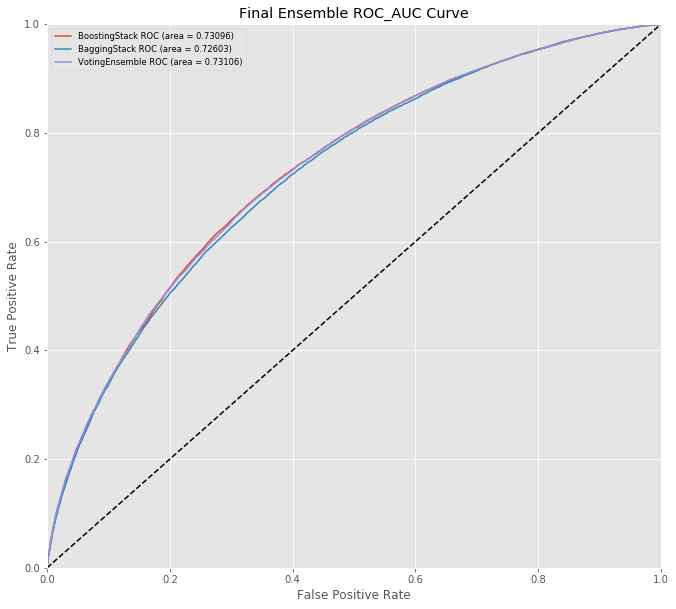

In [0]:
models = [

    {
        'label' : 'BoostingStack',
        'model': boost_sclf,
        'roc_train': train_data,
        'roc_test': test_data,
        'roc_train_class': train_labels,        
        'roc_test_class': test_labels,        
    },
    {
        'label' : 'BaggingStack',
        'model': bag_sclf,
        'roc_train': train_data,
        'roc_test': test_data,
        'roc_train_class': train_labels,        
        'roc_test_class': test_labels,       
    },  
      {
        'label' : 'VotingEnsemble',
        'model': eclf,
        'roc_train': train_data,
        'roc_test': test_data,
        'roc_train_class': train_labels,        
        'roc_test_class': test_labels,       
    }
#     {
#         'label' : 'BoostStack',
#         'model': sclf,
#         'roc_train': train_data,
#         'roc_test': test_data,
#         'roc_train_class': train_labels,        
#         'roc_test_class': test_labels,        
#     }, 
#     {
#         'label' : 'KNN',
#         'model': model5,
#         'roc_train': train_data,
#         'roc_test': test_data,
#         'roc_train_class': train_labels,        
#         'roc_test_class': test_labels,        
#     },  
#     {
#         'label' : 'BoostingStack',
#         'model': boost_sclf,
#         'roc_train': train_data,
#         'roc_test': test_data,
#         'roc_train_class': train_labels,        
#         'roc_test_class': test_labels,        
#     }
]


plt.clf()
plt.figure(figsize=(11,10))
# fit(m['roc_train'], m['roc_train_class'])

for m in models:
    m['model'].probability = True
    probas = m['model'].fit(m['roc_train'], m['roc_train_class']).predict_proba(m['roc_test'])[::,1]
    fpr, tpr, _ = metrics.roc_curve(m['roc_test_class'],  probas)
#     fpr, tpr, thresholds = roc_curve(m['roc_test_class'], probas[:, 1])
    auc = metrics.roc_auc_score(test_labels, probas)
#     r_auc = roc_auc_score(m['roc_test_class'], m['model'].predict(m['roc_test']))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.5f)' % (m['label'], auc))


# plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Final Ensemble ROC_AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()

0:	learn: 0.6922989	total: 141ms	remaining: 42.2s
1:	learn: 0.6914667	total: 282ms	remaining: 42.1s
2:	learn: 0.6906762	total: 429ms	remaining: 42.5s
3:	learn: 0.6898641	total: 576ms	remaining: 42.6s
4:	learn: 0.6890907	total: 732ms	remaining: 43.2s
5:	learn: 0.6883371	total: 874ms	remaining: 42.8s
6:	learn: 0.6875972	total: 1.03s	remaining: 43s
7:	learn: 0.6868707	total: 1.17s	remaining: 42.9s
8:	learn: 0.6861612	total: 1.32s	remaining: 42.7s
9:	learn: 0.6854483	total: 1.47s	remaining: 42.5s
10:	learn: 0.6847402	total: 1.61s	remaining: 42.4s
11:	learn: 0.6840663	total: 1.77s	remaining: 42.5s
12:	learn: 0.6834051	total: 1.92s	remaining: 42.3s
13:	learn: 0.6827278	total: 2.07s	remaining: 42.2s
14:	learn: 0.6820965	total: 2.22s	remaining: 42.2s
15:	learn: 0.6814694	total: 2.37s	remaining: 42s
16:	learn: 0.6808306	total: 2.52s	remaining: 41.9s
17:	learn: 0.6802192	total: 2.66s	remaining: 41.7s
18:	learn: 0.6796047	total: 2.82s	remaining: 41.8s
19:	learn: 0.6790107	total: 2.97s	remaining: 

<Figure size 432x288 with 0 Axes>

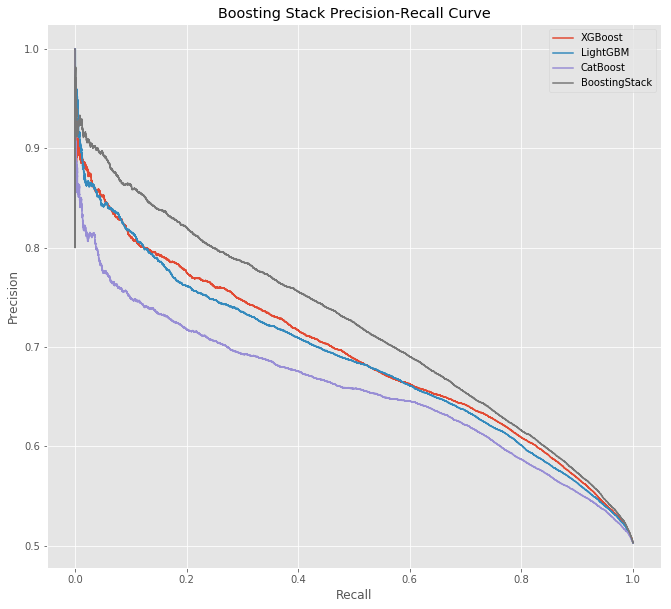

In [0]:
plt.clf()
plt.figure(figsize=(11,10))

for m in models:
    m['model'].probability = True
    probas = m['model'].fit(m['roc_train'], m['roc_train_class']).predict_proba(m['roc_test'])
#     p1 = probas[::,1]
    precision, recall, thresholds = precision_recall_curve(m['roc_test_class'], probas[:, 1])
#     pred_labels = m['model'].predict(m['roc_test'])
#     acc = roc_auc_score(m['roc_test_class'], p1)
    plt.plot(recall, precision, label=(m['label']))


# plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
plt.title('Boosting Stack Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=0, fontsize='medium')
plt.show()